In [1]:
import numpy as np
import seaborn as sns
from model_multi_gpu import ModelMGPU
import keras.backend as K
import tensorflow as tf

from focal_loss import focal_loss

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
input_shape = (299, 299, 3)
n_out = 28

K.clear_session()

tfconfig = tfconfig = tf.ConfigProto(
                gpu_options=tf.GPUOptions(allow_growth=True)
            )
sess = tf.Session(config=tfconfig)
K.set_session(sess)
# create model
model_name = 'wideResnet'

if model_name == 'xception':
    from model.xception import MyXception
    model = MyXception.create_model(
        input_shape=input_shape,
        n_out=n_out)
elif model_name == 'resnet50':
    from model.resnet50 import MyResNet50
    model = MyResNet50.create_model(
        input_shape=input_shape,
        n_out=n_out)
elif model_name == 'wideResnet':
    from model.wide_residual_network import create_model
    model = create_model(input_shape=input_shape, n_out=n_out, dropout=0.5)

model = ModelMGPU(model, 2)

/home/yukimiki/workspace/kaggle/atlas/model/wide_residual_network.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  use_bias=False)(input)
/home/yukimiki/workspace/kaggle/atlas/model/wide_residual_network.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  use_bias=False)(init)
/home/yukimiki/workspace/kaggle/atlas/model/wide_residual_network.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  use_bias=False)(x)
/home/yukimiki/workspace/kaggle/atlas/model/wide_residual_network.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), paddin

Wide Residual Network-16-8 created.


In [3]:
#single_model.load_weights('./tflog/20181113015455-xception-adam-lr0.001-B64-s299-binary-brute-tta-znorm/xception.model')

In [4]:
print('loading train data ...')
x_train = np.load('./data/npy_data/x_train_rgb_{}.npy'.format(input_shape[0]))
y_train = np.load('./data/npy_data/y_train_rgb_{}.npy'.format(input_shape[0]))
print('loading validation data ...')
x_valid = np.load('./data/npy_data/x_valid_rgb_{}.npy'.format(input_shape[0]))
y_valid = np.load('./data/npy_data/y_valid_rgb_{}.npy'.format(input_shape[0]))

loading train data ...
loading validation data ...


In [5]:
from clr import LRFinder

num_samples = len(x_train)
batch_size = 8 * 2
minimum_lr = 1e-6
maximum_lr = 100.
lr_callback = LRFinder(num_samples, batch_size,
                       minimum_lr, maximum_lr,
                       validation_data=(x_valid, y_valid),  # use the validation data for losses
                       validation_sample_rate=20,
                       verbose=True,
                       lr_scale='exp', save_dir='.')

model.compile(
    loss='binary_crossentropy',
    #focal_loss(alpha=.25, gamma=2),
    optimizer='adam',
    metrics=['acc'])

# Ensure that number of epochs = 1 when calling fit()
model.fit(x_train, y_train, epochs=1, batch_size=batch_size, 
          validation_data=(x_valid, y_valid), callbacks=[lr_callback])

Train on 24857 samples, validate on 6215 samples
Epoch 1/1
24848/24857 [============================>.] - ETA: 3s - loss: 2.6238 - acc: 0.9299  - LRFinder: Skipping iteration since loss is 4 times as large as best loss (0.2384)
 - LRFinder: val_loss: 0.8775 - lr = 0.32382447 
24857/24857 [==============================] - 10652s 429ms/step - loss: 2.6232 - acc: 0.9299 - val_loss: 0.8839 - val_acc: 0.9359
	LR Finder : Saved the losses and learning rate values in path : {.}


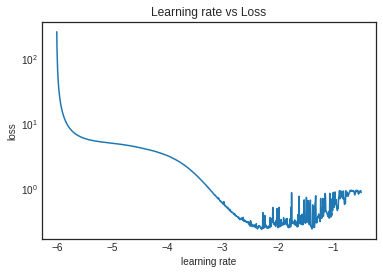

In [6]:
lr_callback.plot_schedule()

In [7]:
x_valid.shape

(6215, 299, 299, 3)

In [8]:
y_valid.shape

(6215, 28)

In [1]:
10/5 *2

4.0